### Load packages

In [1]:
import numpy as np 
import pandas as pd 
import os
from time import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
from numba import jit
import itertools
from seaborn import countplot,lineplot, barplot
from numba import jit
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
from scipy.stats import randint as sp_randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

!ls Data/
!ls Data/robots-best-submission
print ("Ready !")

c:\python\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
'ls' is not recognized as an internal or external command,
operable program or batch file.


Ready !


'ls' is not recognized as an internal or external command,
operable program or batch file.


### Load data

In [2]:
data = pd.read_csv('Data/X_train.csv')
tr = pd.read_csv('Data/X_train.csv')
sub = pd.read_csv('Data/sample_submission.csv')
test = pd.read_csv('Data/X_test.csv')
target = pd.read_csv('Data/y_train.csv')
print ("Data is ready !!")

Data is ready !!


# Data exploration

In [3]:
len(data.measurement_number.value_counts())

128

Each series has 128 measurements. 

**1 serie = 128 measurements**. 

For example, serie with series_id=0 has a surface = *fin_concrete* and 128 measurements.

### There is missing data in test and train data

In [4]:
totalt = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Training")
missing_data.tail()

Missing Data at Training


,Total,Percent
orientation_Y,0,0.0
orientation_X,0,0.0
measurement_number,0,0.0
series_id,0,0.0
row_id,0,0.0


In [5]:
totalt = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([totalt, percent], axis=1, keys=['Total', 'Percent'])
print ("Missing Data at Test")
missing_data.tail()

Missing Data at Test


,Total,Percent
orientation_Y,0,0.0
orientation_X,0,0.0
measurement_number,0,0.0
series_id,0,0.0
row_id,0,0.0


In [6]:
print ("Test has ", (test.shape[0]-data.shape[0])/128, "series more than Train (later I will prove it) = 768 registers")
dif = test.shape[0]-data.shape[0]
print ("Let's check this extra 6 series")
test.tail(768).describe()

Test has  6.0 series more than Train (later I will prove it) = 768 registers
Let's check this extra 6 series


,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3812.500000,63.500000,-0.227899,0.616574,0.090341,-0.038248,-0.003022,-0.027497,0.103820,0.170629,2.832722,-9.351470
std,1.708938,36.973369,0.679676,0.290854,0.048516,0.100461,0.095879,0.079114,0.222543,1.383624,2.212012,2.049869
min,3810.000000,0.000000,-0.981070,0.123660,0.008861,-0.148810,-0.517050,-0.218150,-0.344380,-11.605000,-5.562500,-23.692000
25%,3811.000000,31.750000,-0.943065,0.297930,0.038173,-0.142825,-0.038473,-0.066248,-0.063214,-0.432255,2.031675,-10.113250
50%,3812.500000,63.500000,-0.297575,0.724580,0.105996,-0.049340,-0.007357,-0.011478,0.057392,0.184680,2.972200,-9.334750
75%,3814.000000,95.250000,0.557312,0.816645,0.129050,0.079957,0.041774,0.026707,0.171278,0.818900,3.914600,-8.663825
max,3815.000000,127.000000,0.591450,0.978060,0.148450,0.083127,0.414210,0.291390,0.575400,8.387500,8.958900,4.328300


If we look at the features: orientation, angular velocity and linear acceleration, we can see big differences between **max** and **min** from entire test vs 6 extra test's series (see **linear_acceleration_Z**).

Obviously we are comparing 3810 series vs 6 series so this is not a big deal.

### goup_id will be important !!

In [7]:
target.groupby('group_id').surface.nunique().max()

1

In [8]:
target['group_id'].nunique()

73

**73 groups**
**Each group_id is a unique recording session and has only one surface type **

---

# Feature Engineering

In [9]:
def plot_feature_distribution(df1, df2, label1, label2, features,a=2,b=5):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(17,9))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        sns.kdeplot(df1[feature], bw=0.5,label=label1)
        sns.kdeplot(df2[feature], bw=0.5,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

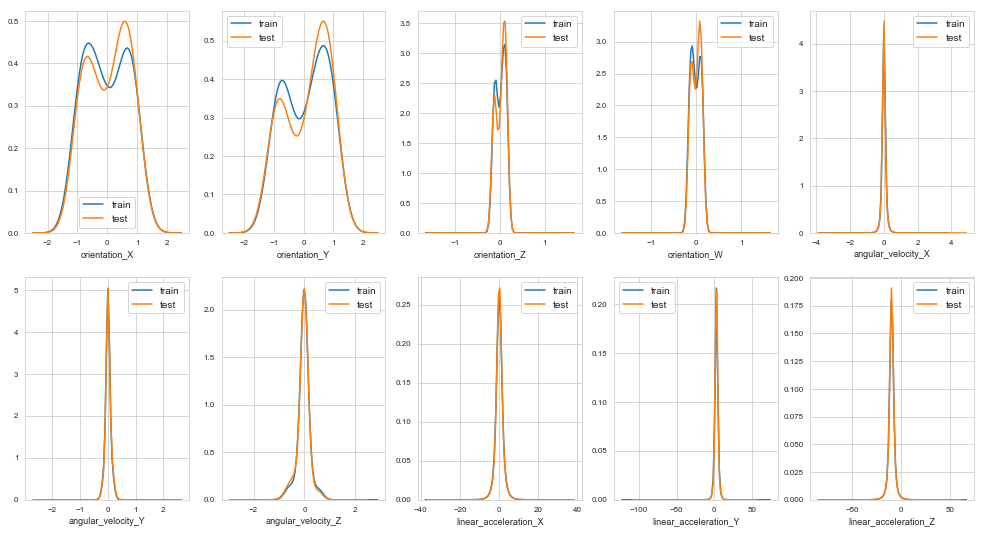

In [10]:
features = data.columns.values[3:]
plot_feature_distribution(data, test, 'train', 'test', features)

Godd news, our basic features have the **same distribution (Normal) on test and training**. There are some differences between *orientation_X* , *orientation_Y* and *linear_acceleration_Y*.

I willl try **StandardScaler** to fix this, and remember: orientation , angular velocity and linear acceleration are measured with different units, scaling might be a good choice.

In [11]:
def plot_feature_class_distribution(classes,tt, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for feature in features:
        i += 1
        plt.subplot(a,b,i)
        for clas in classes:
            ttc = tt[tt['surface']==clas]
            sns.kdeplot(ttc[feature], bw=0.5,label=clas)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

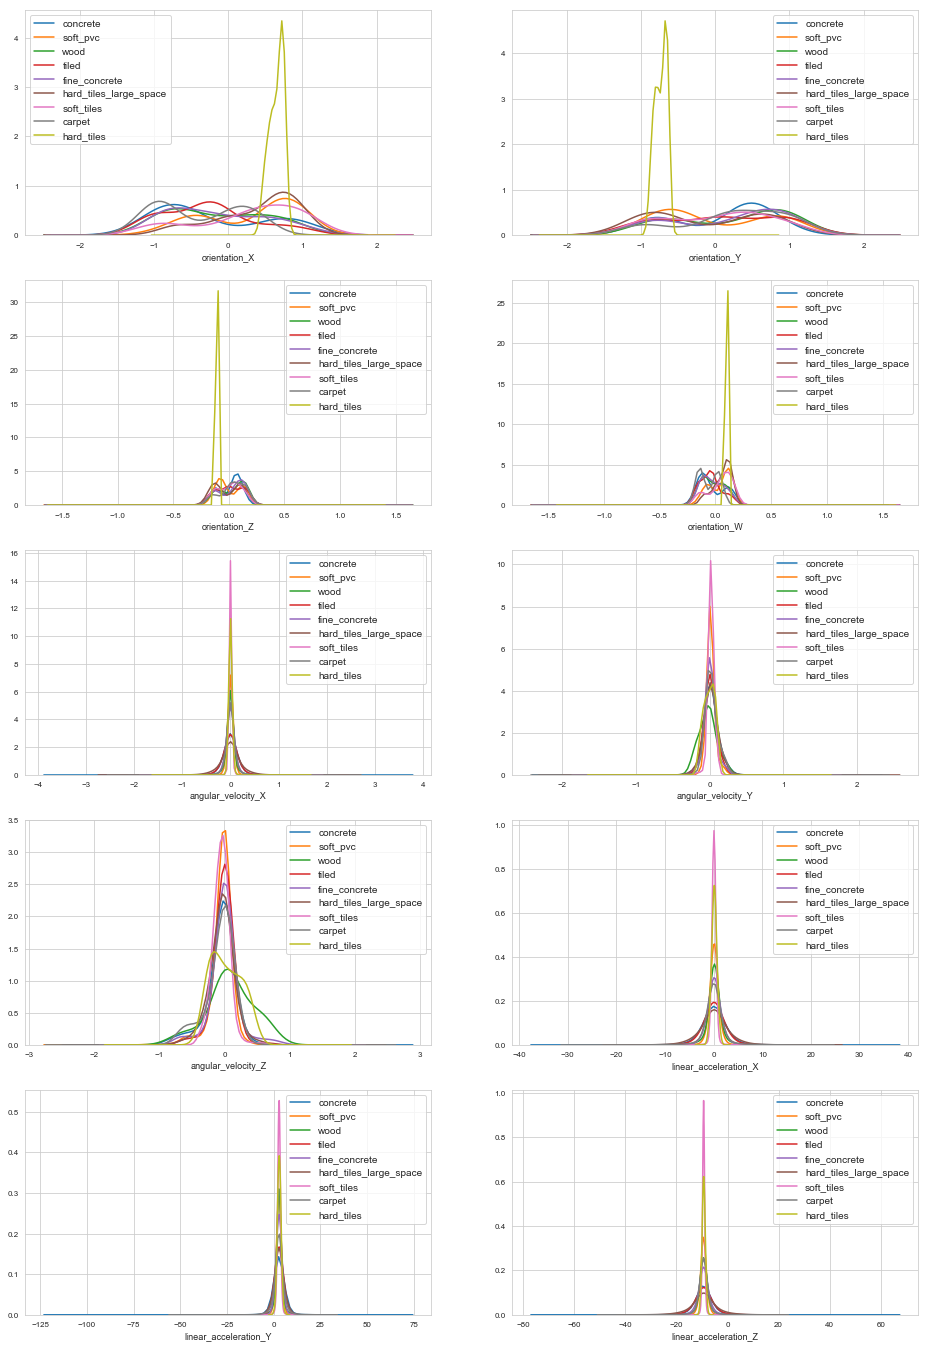

In [12]:
classes = (target['surface'].value_counts()).index
aux = data.merge(target, on='series_id', how='inner')
plot_feature_class_distribution(classes, aux, features)

**Normal distribution**

There are obviously differences between *surfaces* and that's good, we will focus on that in order to classify them better.

Knowing this differences and that variables follow a normal distribution (in most of the cases) we need to add new features like: ```mean, std, median, range ...``` (for each variable).

However, I will try to fix *orientation_X* and *orientation_Y* as I explained before, scaling and normalizing data.

---

### Now with a new scale (more more precision)

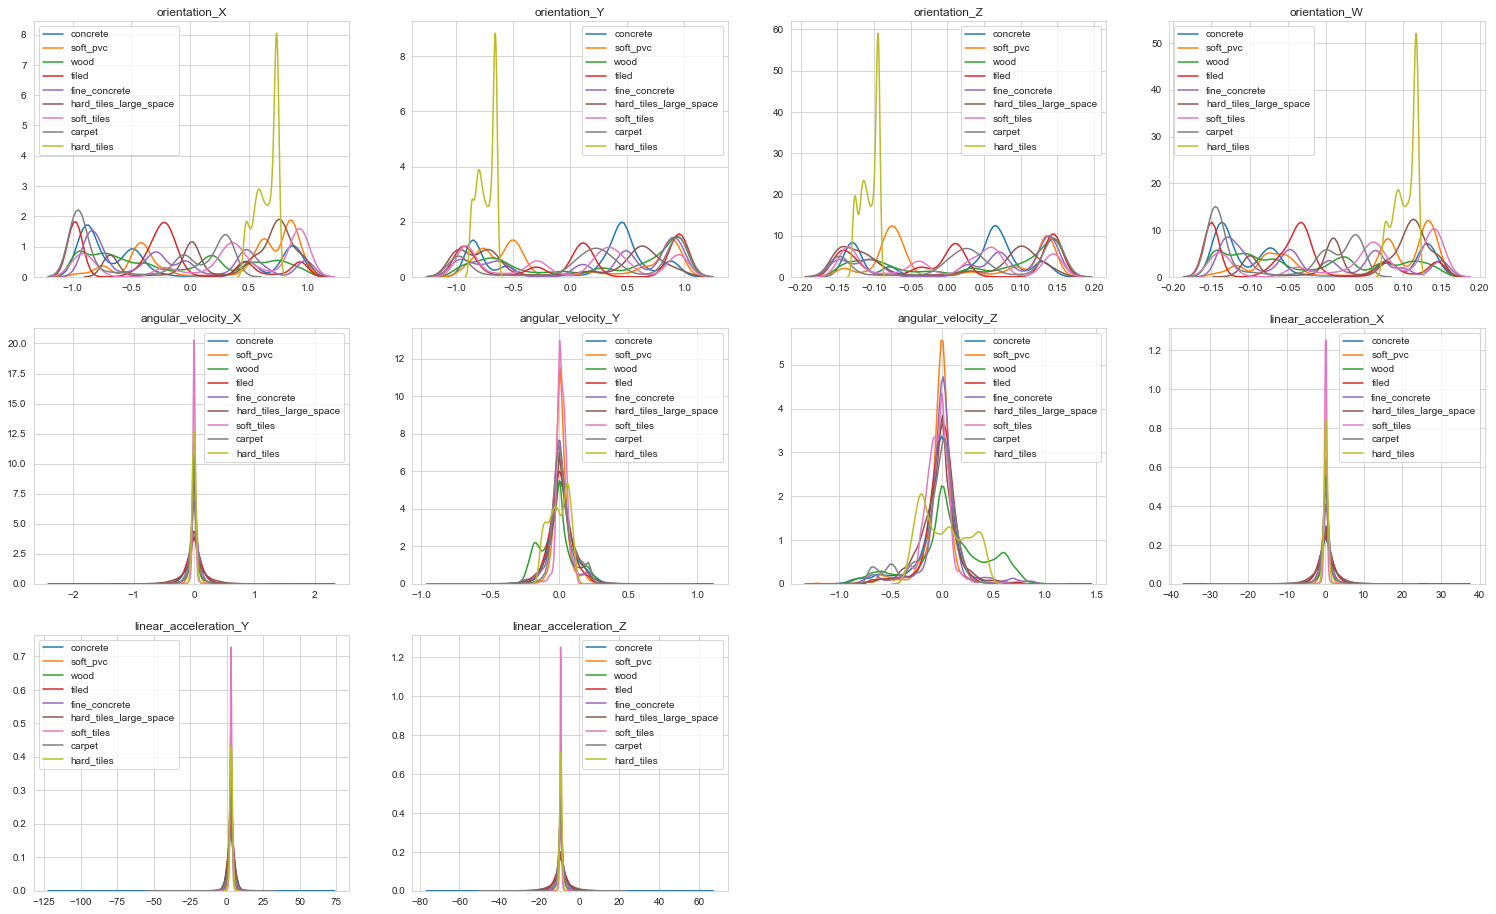

In [13]:
plt.figure(figsize=(26, 16))
for i,col in enumerate(aux.columns[3:13]):
    ax = plt.subplot(3,4,i+1)
    ax = plt.title(col)
    for surface in classes:
        surface_feature = aux[aux['surface'] == surface]
        sns.kdeplot(surface_feature[col], label = surface)

## Step 0 : quaternions

Orientation - quaternion coordinates
You could notice that there are 4 coordinates: X, Y, Z, W.

Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. Quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Here are some articles about it:

http://www.chrobotics.com/library/understanding-quaternions

http://www.tobynorris.com/work/prog/csharp/quatview/help/orientations_and_quaternions.htm

Basically 3D coordinates are converted to 4D vectors.

In [14]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [15]:
def fe_step0 (actual):
    
    # https://www.mathworks.com/help/aeroblks/quaternionnorm.html
    # https://www.mathworks.com/help/aeroblks/quaternionmodulus.html
    # https://www.mathworks.com/help/aeroblks/quaternionnormalize.html
        
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual


> *Are there any reasons to not automatically normalize a quaternion? And if there are, what quaternion operations do result in non-normalized quaternions?*

Any operation that produces a quaternion will need to be normalized because floating-point precession errors will cause it to not be unit length.
I would advise against standard routines performing normalization automatically for performance reasons. 
Any competent programmer should be aware of the precision issues and be able to normalize the quantities when necessary - and it is not always necessary to have a unit length quaternion.
The same is true for vector operations.

source: https://stackoverflow.com/questions/11667783/quaternion-and-normalization

In [16]:
data = fe_step0(data)
test = fe_step0(test)
print(data.shape)
data.head()

(487680, 19)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


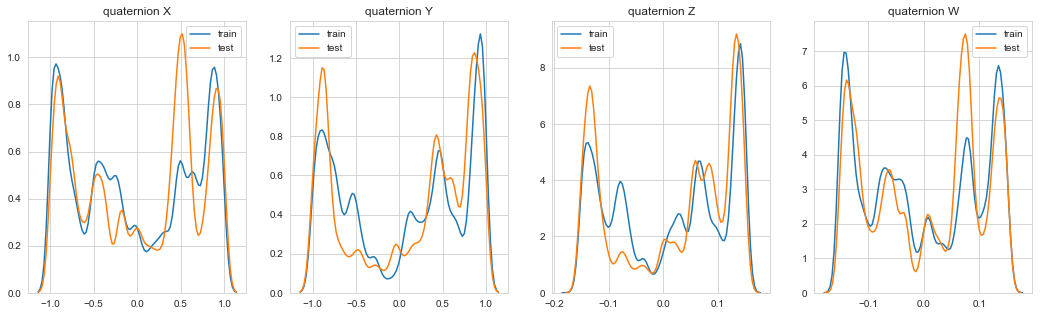

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('quaternion X')
sns.kdeplot(data['norm_X'], ax=ax1, label="train")
sns.kdeplot(test['norm_X'], ax=ax1, label="test")

ax2.set_title('quaternion Y')
sns.kdeplot(data['norm_Y'], ax=ax2, label="train")
sns.kdeplot(test['norm_Y'], ax=ax2, label="test")

ax3.set_title('quaternion Z')
sns.kdeplot(data['norm_Z'], ax=ax3, label="train")
sns.kdeplot(test['norm_Z'], ax=ax3, label="test")

ax4.set_title('quaternion W')
sns.kdeplot(data['norm_W'], ax=ax4, label="train")
sns.kdeplot(test['norm_W'], ax=ax4, label="test")

plt.show()

## Step 1: (x, y, z, w) -> (x,y,z)   quaternions to euler angles

In [18]:
def fe_step1 (actual):
    """Quaternions to Euler Angles"""
    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual

In [19]:
data = fe_step1(data)
test = fe_step1(test)
print (data.shape)
data.head()

(487680, 22)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


![](https://d2gne97vdumgn3.cloudfront.net/api/file/UMYT4v0TyIgtyGm8ZXDQ)

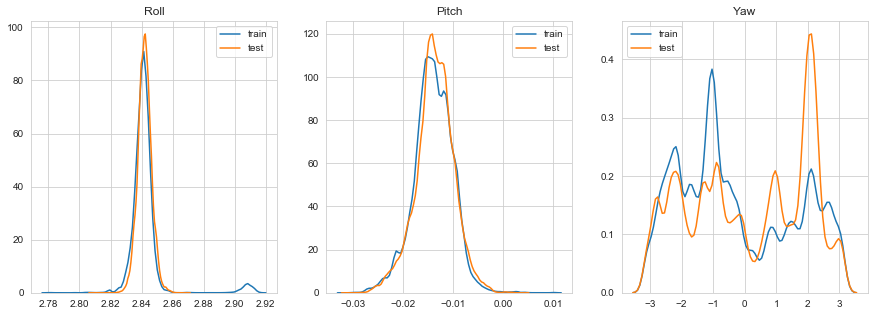

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))

ax1.set_title('Roll')
sns.kdeplot(data['euler_x'], ax=ax1, label="train")
sns.kdeplot(test['euler_x'], ax=ax1, label="test")

ax2.set_title('Pitch')
sns.kdeplot(data['euler_y'], ax=ax2, label="train")
sns.kdeplot(test['euler_y'], ax=ax2, label="test")

ax3.set_title('Yaw')
sns.kdeplot(data['euler_z'], ax=ax3, label="train")
sns.kdeplot(test['euler_z'], ax=ax3, label="test")

plt.show()

**Euler angles** are really important, and we have a problem with Z.

### Why Orientation_Z (euler angle Z) is so important?

We have a robot moving around, imagine a robot moving straight through different surfaces (each with different features), for example concrete and hard tile floor. Our robot can can **bounce** or **balance** itself a little bit on if the surface is not flat and smooth, that's why we need to work with quaternions and take care of orientation_Z.

![](https://lifeboat.com/blog.images/robot-car-find-share-on-giphy.gif.gif)

In [21]:
data.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,...,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,...,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,...,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,...,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,...,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,...,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


## Step 2: + Basic features

In [22]:
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df
    

In [23]:
%%time
data = feat_eng(data)
test = feat_eng(test)
print ("New features: ",data.shape)

New features:  (3810, 276)
Wall time: 1min 39s


In [24]:
data.head()

,orientation_X_mean,orientation_X_median,orientation_X_max,orientation_X_min,orientation_X_std,orientation_X_range,orientation_X_maxtoMin,orientation_X_mean_abs_chg,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,...,acc_vs_vel_max,acc_vs_vel_min,acc_vs_vel_std,acc_vs_vel_range,acc_vs_vel_maxtoMin,acc_vs_vel_mean_abs_chg,acc_vs_vel_mean_change_of_abs_change,acc_vs_vel_abs_max,acc_vs_vel_abs_min,acc_vs_vel_abs_avg
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.758530,-0.75822,-0.75953,0.000363,0.00131,0.998275,0.000015,2.380952e-07,0.75953,...,995.561076,56.133014,135.641510,939.428062,17.735749,114.896199,1.309785,995.561076,56.133014,525.847045
1,-0.958606,-0.958595,-0.95837,-0.95896,0.000151,0.00059,0.999385,0.000023,-4.761905e-07,0.95896,...,611.826712,32.938319,88.488750,578.888393,18.574922,57.943094,0.508448,611.826712,32.938319,322.382516
2,-0.512057,-0.512035,-0.50944,-0.51434,0.001377,0.00490,0.990473,0.000041,0.000000e+00,0.51434,...,904.269577,52.834789,132.789650,851.434788,17.115041,83.878164,-0.078679,904.269577,52.834789,478.552183
3,-0.939169,-0.939170,-0.93884,-0.93968,0.000227,0.00084,0.999106,0.000026,-6.349206e-07,0.93968,...,805.924410,11.305069,112.264757,794.619341,71.288762,76.773215,0.928182,805.924410,11.305069,408.614740
4,-0.891301,-0.890940,-0.88673,-0.89689,0.002955,0.01016,0.988672,0.000080,7.936508e-08,0.89689,...,111.588333,39.895232,16.611029,71.693101,2.797034,5.618844,-0.003968,111.588333,39.895232,75.741783


## Correlations (Part II)

In [25]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
corr_matrix = data.corr().abs()
raw_corr = data.corr()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
top_corr = pd.DataFrame(sol).reset_index()
top_corr.columns = ["var1", "var2", "abs corr"]
# with .abs() we lost the sign, and it's very important.
for x in range(len(top_corr)):
    var1 = top_corr.iloc[x]["var1"]
    var2 = top_corr.iloc[x]["var2"]
    corr = raw_corr[var1][var2]
    top_corr.at[x, "raw corr"] = corr

In [26]:
top_corr.head(15)

,var1,var2,abs corr,raw corr
0,norm_quat_max,norm_quat_abs_max,1.0,1.0
1,euler_x_max,euler_x_abs_max,1.0,1.0
2,norm_quat_min,norm_quat_abs_min,1.0,1.0
3,acc_vs_vel_max,acc_vs_vel_abs_max,1.0,1.0
4,mod_quat_max,mod_quat_abs_max,1.0,1.0
5,totl_anglr_vel_min,totl_anglr_vel_abs_min,1.0,1.0
6,totl_xyz_max,totl_xyz_abs_max,1.0,1.0
7,euler_x_min,euler_x_abs_min,1.0,1.0
8,totl_xyz_min,totl_xyz_abs_min,1.0,1.0
9,mod_quat_min,mod_quat_abs_min,1.0,1.0


### Filling missing and infinite data by zeroes

In [27]:
data.fillna(0,inplace=True)
test.fillna(0,inplace=True)
data.replace(-np.inf,0,inplace=True)
data.replace(np.inf,0,inplace=True)
test.replace(-np.inf,0,inplace=True)
test.replace(np.inf,0,inplace=True)

## Label encoding

In [28]:
target.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [29]:
target['surface'] = le.fit_transform(target['surface'])

In [30]:
target['surface'].value_counts()

1    779
5    732
8    607
7    514
2    363
4    308
6    297
0    189
3     21
Name: surface, dtype: int64

In [31]:
target.head()

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6


# Run Model

**use random_state at Random Forest**

if you don't use random_state you will get a different solution everytime, sometimes you will be lucky, but other times you will lose your time comparing.

In [34]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [36]:
datamodel = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = model, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 10, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
rf_random.fit(data,target['surface'])


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed: 44.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 69.7min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [37]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': False}

In [40]:
best_random = rf_random.best_estimator_
predicted = best_random.predict(test)
sub['surface'] = le.inverse_transform(predicted)
sub.to_csv('submission_rf_new_random_hp.csv', index=False)
sub.head()    

,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,carpet
4,4,soft_tiles


In [ ]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((test.shape[0],9))
measured= np.zeros((data.shape[0]))
score = 0

In [ ]:
for times, (trn_idx, val_idx) in enumerate(folds.split(data.values,target['surface'].values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=5, n_jobs=-1)
    model.fit(data.iloc[trn_idx],target['surface'][trn_idx])
    measured[val_idx] = model.predict(data.iloc[val_idx])
    predicted += model.predict_proba(test)/folds.n_splits
    score += model.score(data.iloc[val_idx],target['surface'][val_idx])
    print("Fold: {} score: {}".format(times,model.score(data.iloc[val_idx],target['surface'][val_idx])))

    importances = model.feature_importances_
    indices = np.argsort(importances)
    features = data.columns
    
    if model.score(data.iloc[val_idx],target['surface'][val_idx]) > 0.92000:
        hm = 30
        plt.figure(figsize=(7, 10))
        plt.title('Feature Importances')
        plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
        plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()

    gc.collect()

In [ ]:
print('Avg Accuracy RF', score / folds.n_splits)

In [ ]:
confusion_matrix(measured,target['surface'])

### Confusion Matrix Plot

In [ ]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [ ]:
plot_confusion_matrix(target['surface'], measured, le.classes_)

### Submission (Part I)

In [ ]:
sub['surface'] = le.inverse_transform(predicted.argmax(axis=1))
sub.to_csv('submission_rf_new.csv', index=False)
sub.head()

### Best Submission

In [ ]:
best_sub = pd.read_csv('Data/robots-best-submission/mybest0.73.csv')
best_sub.to_csv('best_submission.csv', index=False)
best_sub.head(10)

## References

[1] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b

[2] https://www.kaggle.com/artgor/where-do-the-robots-drive

[3] https://www.kaggle.com/gpreda/robots-need-help

[4] https://www.kaggle.com/vanshjatana/help-humanity-by-helping-robots-4e306b by [@vanshjatana](https://www.kaggle.com/vanshjatana)

# ABOUT Submissions & Leaderboard

This kernel [distribution hack](https://www.kaggle.com/donkeys/distribution-hack) by [@donkeys](https://www.kaggle.com/donkeys) simply produces 9 output files, one for each target category. 
I submitted each of these to the competition to see how much of each target type exists in the test set distribution. Results:

- carpet 0.06
- concrete 0.16
- fine concrete 0.09
- hard tiles 0.06
- hard tiles large space 0.10
- soft pvc 0.17
- soft tiles 0.23
- tiled 0.03
- wood 0.06

Also posted a discussion [thread](https://www.kaggle.com/c/career-con-2019/discussion/85204)



**by [@ninoko](https://www.kaggle.com/ninoko)**

I've probed the public leaderboard and this is what I got
There are much less surfaces like wood or tiled, and much more soft and hard tiles in public leaderboard. This can be issue, why CV and LB results differ strangely.

![graph](https://i.imgur.com/DoFc3mW.png)

**I will analyze my best submissions in order to find something interesting.**

Please, feel free to optimize this code.

In [ ]:
sub073 = pd.read_csv('Datat/robots-best-submission/mybest0.73.csv')
sub072 = pd.read_csv('Data/robots-best-submission/sub_0.72.csv')
sub072_2 = pd.read_csv('Data/robots-best-submission/sub_0.72_2.csv')
sub071 = pd.read_csv('Data/robots-best-submission/sub_0.71.csv')
sub06 = pd.read_csv('Data/robots-best-submission/sub_0.6.csv')

sub073 = sub073.rename(columns = {'surface':'surface073'})
sub072 = sub072.rename(columns = {'surface':'surface072'})
sub072_2 = sub072_2.rename(columns = {'surface':'surface072_2'})
sub071 = sub071.rename(columns = {'surface':'surface071'})
sub06 = sub06.rename(columns = {'surface':'surface06'})
print ("Submission data is ready")

In [ ]:
sub073.head()

In [ ]:
subtest = pd.concat([sub073['series_id'], sub073['surface073'], sub072['surface072'], sub071['surface071'], sub06['surface06']], axis=1)
subtest.head()

In [ ]:
differents = []
for i in range (0,subtest.shape[0]): 
    labels = list(subtest.iloc[i,1:])
    result = len(set(labels))>1
    if result:
        differents.append((i, str(labels)))
        
differents = pd.DataFrame(differents, columns=['idx','group']) 
differents.head()

For example the serie with **series_id = 2** has the following predicition:

```
['tiled', 'tiled', 'tiled', 'fine_concrete']
```

This means that my best submissions (*0.73, 0.72 and  0.71 LB* ) predicted the same: **tiled**, but a worst submission (*0.6 LB*) would have predicted **fine_concrete**.

---

### So... Why is this interesting?

In order to improve our classification, LB is indicating us wich kind of surfaces are confused with others.
In that example, ```tiled``` and ```fine_concrete``` are being **confused** (maybe because the two surfaces are **alike**)

---

As you can see bellow, we have **177 cases of confusion**
I'm going to plot the tp 10% and see what happens.

In [ ]:
differents['group'].nunique()

In [ ]:
differents['count'] = differents.groupby('group')['group'].transform('count')
differents = differents.sort_values(by=['count'], ascending=False)
differents = differents.drop(['idx'],axis=1)
differents = differents.drop_duplicates()

In [ ]:
differents.head(10)

We can see that **wood** and **fine_concrete** are really hard to guess.

### Maybe this is the most interesting part, the difference between a 0.73 and 0.72 submission.

In [ ]:
differents.tail(10)

Remember the order at the array is [0.73LB, 0.72LB, 0.71LB, 06LB].
Series with ```series_id```= 575, 1024, 911, 723, 148, 338 are really interesting because they show important differences between surfaces that often are being confused.

## Next Step ??

- I will create a test dataset with those special cases and then I will ad a new CV stage where I will try to classify those surfaces correctly.
- I will look for surfaces distinctive features.